In [ ]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy.stats import norm

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, LeakyReLU, Dropout
from keras import backend
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import get_custom_objects
from keras import backend as K
from keras.activations import elu, sigmoid
import tensorflow as tf

In [ ]:
tf.keras.backend.set_floatx('float64')

In [ ]:
N = norm.cdf
def BS_CALL(S, K, T, r, q , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*(math.exp(-q*T))* N(d1) - K * np.exp(-r*T)* N(d2)

In [ ]:
price = np.random.uniform(10, 20, 300000)
strike = np.random.uniform(10, 20, 300000)
time = np.random.uniform(0.1, 3, 300000)
intrest = np.random.uniform(0.01, 0.03, 300000)
divident = np.random.uniform(0, 0.03, 300000)
volatility = np.random.uniform(0.05, 0.3, 300000)
call = np.zeros(300000)

In [ ]:
for i in range(0,300000):
  call[i] = BS_CALL(price[i],strike[i],time[i],intrest[i],divident[i],volatility[i])

In [ ]:
df = pd.DataFrame()

In [ ]:
df['Stock'] = price.tolist()
df['Strike'] = strike.tolist()
df['Time'] = time.tolist()
df['Intrest'] = intrest.tolist()
df['Divident'] = divident.tolist()
df['Call'] = call.tolist()
df['Volatility'] = volatility.tolist()

In [ ]:
df_filtered = df[df['Call'] <= 10]
df_filtered = df_filtered[df_filtered['Call'] >= 0.001]

In [ ]:
df_filtered['Stock'] = df_filtered['Stock'].div(df_filtered.Strike)
df_filtered['Call'] = df_filtered['Call'].div(df_filtered.Strike)
MinCall = df_filtered.loc[df_filtered["Call"].idxmin()].Call
df_filtered['Strike'] = 1
Strike = df_filtered.Strike.values
df_filtered = df_filtered.drop('Strike', axis=1)

In [ ]:
from scipy.stats import norm
df_filtered['Call'] = df_filtered['Call'] - 0.5

df_filtered['Volatility'] = norm.cdf(np.log(df_filtered['Stock'])/(df_filtered['Volatility'] * np.sqrt(df_filtered['Time'])))

In [ ]:
prices = df_filtered.values

In [ ]:
X = prices[:,:5]
y = prices[:,5:6]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def custom_activation(x):
    return (K.softplus(x)-0.5)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [ ]:
def MELU(z):
  cond = K.greater(z, 0)
  return K.switch(cond, (((0.5*(K.pow((z),2)))+(0.02*(z)))/((z)+0.040816326)),0.49*(K.exp(z)-1))

get_custom_objects().update({'MELU': Activation(MELU)})

In [ ]:
from pandas.core.arrays.arrow.array import Any
nodes = 128

# Create Model
model = Sequential()

# Layer 1
model.add(Dense(nodes , input_shape=(5,)))
model.add(Activation(LeakyReLU(1.0)))

# Layer 2
model.add(Dense(nodes))
model.add(Activation (MELU))

# Layer 3
model.add(Dense(nodes))
model.add(Activation (MELU))

# Layer 4 - Output Layer
model.add(Dense(1))
model.add(Activation(custom_activation))

In [ ]:
# optimizer = keras.optimizers.Adam(clipnorm = model.optimizer.clipnorm )

In [ ]:
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras.backend as K
import numpy as np

In [ ]:
def my_callback(epoch, lr):
    if epoch == 1:
      weights = model.layers[7].get_weights()
      norm = np.sqrt(sum(np.sum(K.get_value(w)) for w in weights))
      model.optimizer.clipnorm = norm
      return lr

    else:
      return lr

In [ ]:
lrs = LearningRateScheduler(my_callback)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              min_lr=0.00001,
                              verbose=1)

In [ ]:
model.compile(loss='MSE',
              optimizer='adam',)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [ ]:
model.fit(X_train, y_train, epochs = 15, batch_size = 128, validation_split= 0.1, callbacks=[lrs,reduce_lr])

Epoch 1/15
1548/1548 [==============================] - 15s 9ms/step - loss: 0.0095 - val_loss: 0.0053 - lr: 1.0000e-03
Epoch 2/15
1548/1548 [==============================] - 11s 7ms/step - loss: 0.0049 - val_loss: 0.0041 - lr: 1.0000e-03
Epoch 3/15
1548/1548 [==============================] - 11s 7ms/step - loss: 0.0028 - val_loss: 0.0020 - lr: 1.0000e-03
Epoch 4/15
1548/1548 [==============================] - 11s 7ms/step - loss: 0.0018 - val_loss: 0.0014 - lr: 1.0000e-03
Epoch 5/15
1548/1548 [==============================] - 11s 7ms/step - loss: 0.0014 - val_loss: 0.0015 - lr: 1.0000e-03
Epoch 6/15
1548/1548 [==============================] - 11s 7ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 1.0000e-03
Epoch 7/15
1548/1548 [==============================] - 11s 7ms/step - loss: 8.8843e-04 - val_loss: 6.1481e-04 - lr: 1.0000e-03
Epoch 8/15
1548/1548 [==============================] - 11s 7ms/step - loss: 6.7975e-04 - val_loss: 4.6480e-04 - lr: 1.0000e-03
Epoch 9/15
1548/1548 [==

In [ ]:
predictions = model.predict(X_test)

1720/1720 [==============================] - 5s 3ms/step


In [ ]:
predictions

array([[0.55394771],
       [0.38772921],
       [0.09933739],
       ...,
       [0.14435047],
       [0.02817588],
       [0.65146154]])

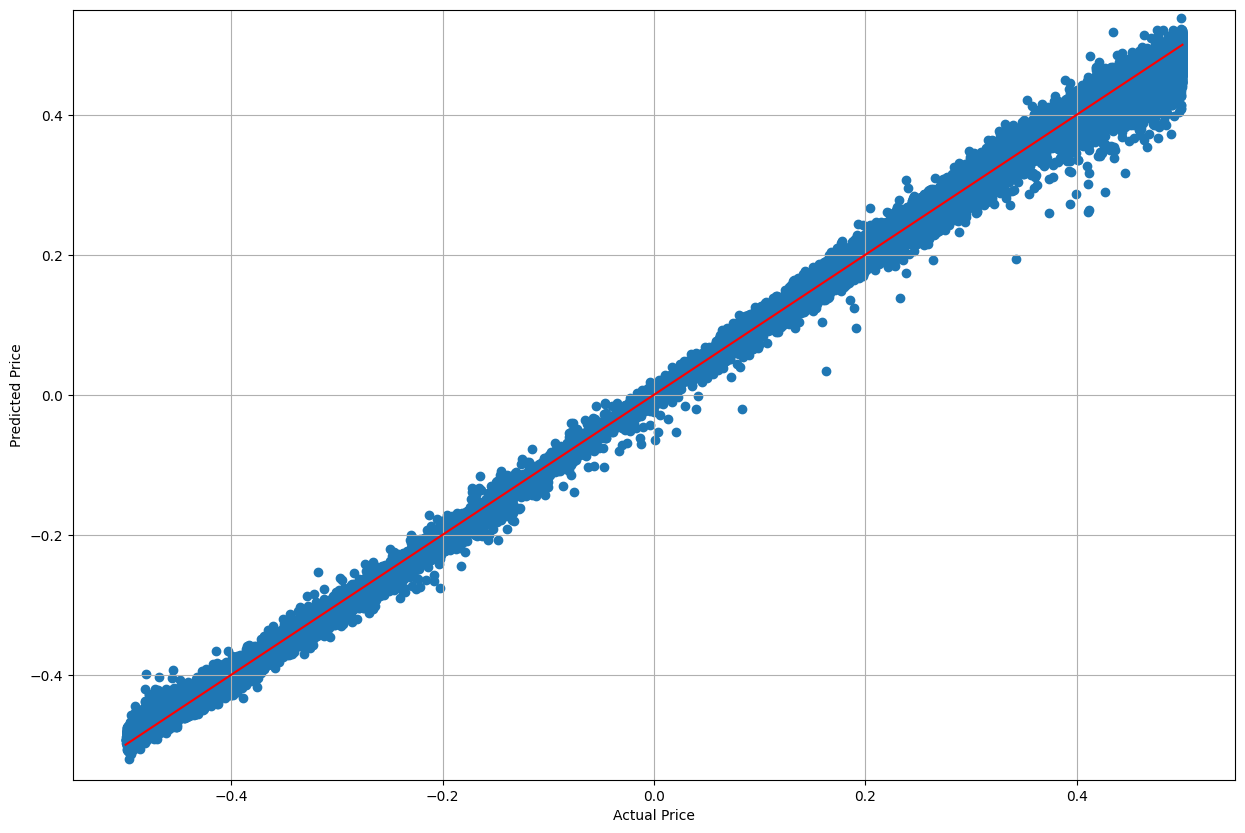

In [ ]:
#out sample(20)
plt.figure(figsize = (15,10))
plt.scatter((y_test)-0.5, (predictions)-0.5)
plt.axis((-0.55, 0.55, -0.55, 0.55))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([-0.5,0.5], [-0.5,0.5], 'r')
plt.grid(True)

In [ ]:
InSamplePredictions = model.predict(X_train)

6880/6880 [==============================] - 16s 2ms/step


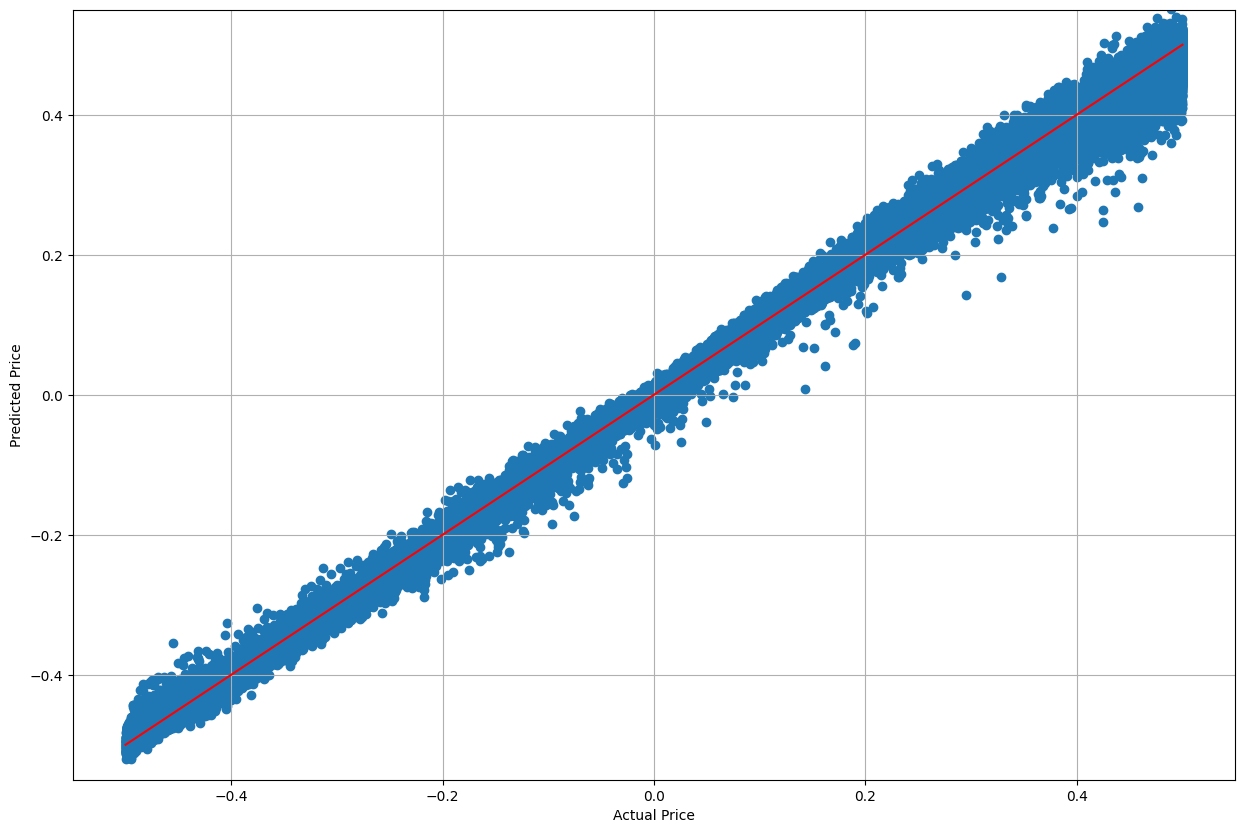

In [ ]:
#in sample (80)
plt.figure(figsize = (15,10))
plt.scatter((y_train)-0.5, (InSamplePredictions)-0.5)
plt.axis((-0.55, 0.55, -0.55, 0.55))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([-0.5,0.5], [-0.5,0.5], 'r')
plt.grid(True)